# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../data/input/input_dataset.csv')

print('Before dropping rows with NA values \t: ', df.shape)
df = df.dropna(axis=0).reset_index(drop=True)
print('After dropping rows with NA values \t: ', df.shape)

Before dropping rows with NA values 	:  (3297, 31)
After dropping rows with NA values 	:  (3297, 31)


In [4]:
df.head()

,Referee,Day Of Week,Round,Days,Shots,ShotsOT,Corners,Fouls,YCards,RCards,GoalsScored,GoalsConceded,GoalsDiff,HTGoalsScored,HTGoalsConceded,HTGoalsDiff,Points,WinPercent,WinStreak,UnbPercent,UnbStreak,Def,Mid,Att,Ovr,LastSeasonRank,PromotedMatchup,WinnerOdd,DrawOdd,Venue,Result
0,L Probert,Sat,1.0,-4,10.4,6.6,3.8,-1.8,0.0,0.0,0.8,0.4,2.0,0.0,0.4,-2.0,0.4,20.0,0.0,0.0,1.0,7,8,8,7.67,-12,0,-9.71,5.50,Etihad Stadium,W
1,M Halsey,Sat,1.0,1,-1.0,-0.2,0.0,-1.8,0.4,0.0,0.2,0.0,1.0,0.4,0.2,1.0,-0.2,0.0,0.0,-20.0,-1.0,1,1,-2,0.00,1,0,-2.25,3.30,Bet365 Stadium,D
2,L Mason,Sat,1.0,0,6.8,5.0,1.8,-0.2,0.4,0.2,1.6,0.6,5.0,1.4,1.0,2.0,0.4,0.0,0.0,40.0,7.0,3,0,-1,0.67,-6,0,-6.56,4.20,Goodison Park,W
3,L Probert,Sun,1.0,0,3.4,2.2,2.0,0.2,-0.6,0.0,1.8,0.6,6.0,0.4,0.4,0.0,1.0,20.0,0.0,60.0,5.0,1,2,1,1.34,-4,0,-3.58,3.75,Craven Cottage,L
4,P Dowd,Sun,1.0,-1,-2.4,-1.8,-0.6,0.6,-1.0,0.0,-0.4,-1.2,4.0,0.2,0.0,1.0,1.0,20.0,0.0,60.0,6.0,-1,-3,-5,-3.00,-1,0,-1.50,3.30,Carrow Road,W


# 3. Feature Selection

In [5]:
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [6]:
df.columns

Index(['Referee', 'Day Of Week', 'Round', 'Days', 'Shots', 'ShotsOT',
       'Corners', 'Fouls', 'YCards', 'RCards', 'GoalsScored', 'GoalsConceded',
       'GoalsDiff', 'HTGoalsScored', 'HTGoalsConceded', 'HTGoalsDiff',
       'Points', 'WinPercent', 'WinStreak', 'UnbPercent', 'UnbStreak', 'Def',
       'Mid', 'Att', 'Ovr', 'LastSeasonRank', 'PromotedMatchup', 'WinnerOdd',
       'DrawOdd', 'Venue', 'Result'],
      dtype='object')

## 3.1 BORUTA Feature Selection

In [7]:
from sklearn.preprocessing import LabelEncoder

# label encode referee categorical data
ref_le = LabelEncoder()
df['Referee'] = ref_le.fit_transform(df['Referee'])

# label encode day_of_week categorical data
dayOfWeek_le = LabelEncoder()
df['Day Of Week'] = dayOfWeek_le.fit_transform(df['Day Of Week'])

# label encode venue categorical data
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

In [8]:
# dict(zip(venue_le.classes_, range(len(venue_le.classes_))))

In [9]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [10]:
y = df.Result
X = df.drop("Result", axis=1)
colnames = X.columns

# using the BorutaPy function
rf = RandomForestClassifier(n_jobs = -1, class_weight="balanced_subsample", max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto", random_state=1)
feat_selector.fit(X.values, y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

boruta_score

,Features,Score
24,Ovr,1.00
23,Att,1.00
28,DrawOdd,1.00
27,WinnerOdd,1.00
4,Shots,1.00
5,ShotsOT,1.00
6,Corners,1.00
16,Points,1.00
25,LastSeasonRank,1.00
21,Def,1.00


In [11]:
# drop features with less than 0.5
treshold = 0.5
elim_features = boruta_score[boruta_score['Score'] < treshold]['Features'].tolist()

df = df.drop(elim_features, axis=1)

In [12]:
df.head()

,Shots,ShotsOT,Corners,Fouls,GoalsScored,GoalsConceded,GoalsDiff,HTGoalsScored,HTGoalsDiff,Points,WinPercent,UnbPercent,UnbStreak,Def,Mid,Att,Ovr,LastSeasonRank,WinnerOdd,DrawOdd,Venue,Result
0,10.4,6.6,3.8,-1.8,0.8,0.4,2.0,0.0,-2.0,0.4,20.0,0.0,1.0,7,8,8,7.67,-12,-9.71,5.50,12,W
1,-1.0,-0.2,0.0,-1.8,0.2,0.0,1.0,0.4,1.0,-0.2,0.0,-20.0,-1.0,1,1,-2,0.00,1,-2.25,3.30,1,D
2,6.8,5.0,1.8,-0.2,1.6,0.6,5.0,1.4,2.0,0.4,0.0,40.0,7.0,3,0,-1,0.67,-6,-6.56,4.20,14,W
3,3.4,2.2,2.0,0.2,1.8,0.6,6.0,0.4,0.0,1.0,20.0,60.0,5.0,1,2,1,1.34,-4,-3.58,3.75,7,L
4,-2.4,-1.8,-0.6,0.6,-0.4,-1.2,4.0,0.2,1.0,1.0,20.0,60.0,6.0,-1,-3,-5,-3.00,-1,-1.50,3.30,6,W


In [13]:
df.shape

(3297, 22)

## 3.2 Correlation Analysis

C:\Users\choibs\AppData\Local\Temp\ipykernel_8080\1732528662.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr('spearman'), annot=True)


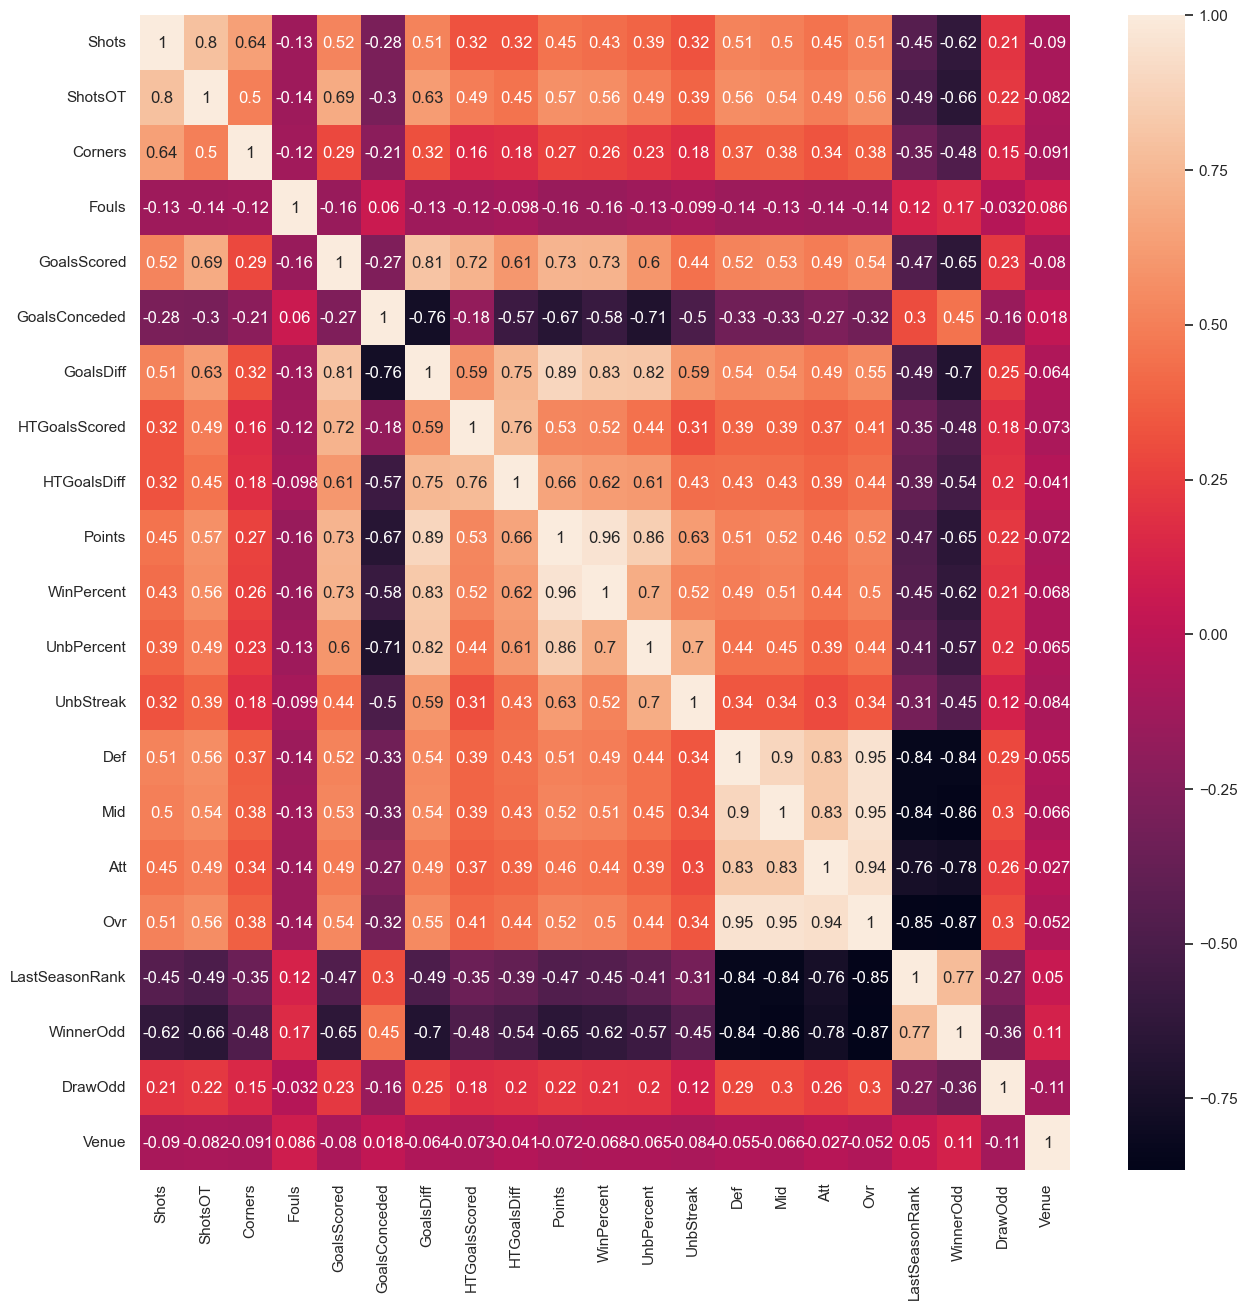

In [14]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr('spearman'), annot=True)
plt.show()

In [15]:
# Take one of Shots, ShotsOT
# Take one of GoalsScored, GoalsConceded, GoalsDiff, HTGoalsScored, HTGoalsDiff, Points, WinPercent, UnbPercent
# Take one of Def, Mid, Att, Ovr, LastSeasonRank, WinnerOdd

df = df.drop([
              'ShotsOT',
              'GoalsScored', 'GoalsConceded', 'GoalsDiff', 'HTGoalsScored', 'HTGoalsDiff', 'WinPercent', 'UnbPercent',
              'Def', 'Mid', 'Att', 'Ovr', 'WinnerOdd'
             ], axis=1)

C:\Users\choibs\AppData\Local\Temp\ipykernel_8080\1310028722.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr('spearman'), annot=True)


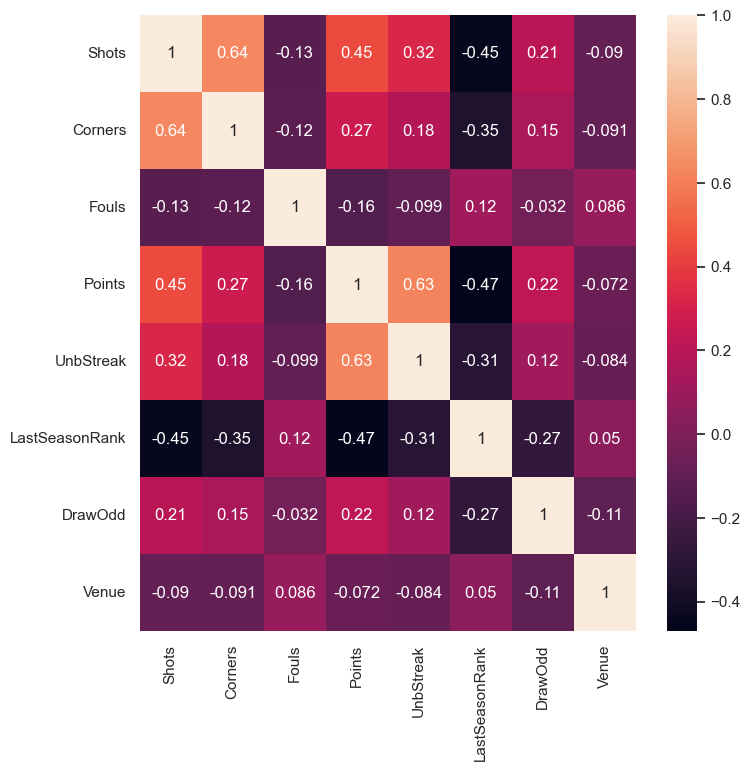

In [16]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr('spearman'), annot=True)
plt.show()

In [17]:
df.head()

,Shots,Corners,Fouls,Points,UnbStreak,LastSeasonRank,DrawOdd,Venue,Result
0,10.4,3.8,-1.8,0.4,1.0,-12,5.50,12,W
1,-1.0,0.0,-1.8,-0.2,-1.0,1,3.30,1,D
2,6.8,1.8,-0.2,0.4,7.0,-6,4.20,14,W
3,3.4,2.0,0.2,1.0,5.0,-4,3.75,7,L
4,-2.4,-0.6,0.6,1.0,6.0,-1,3.30,6,W


In [18]:
df.shape

(3297, 9)

## 3.3 BoxPlot Analysis

Next, we plot boxplots between all the features and the target variable (Result) to verify the relationship between all variables and the Result. The idea here is to identify and eliminate variables that do not contribute to the prediction of the Result variable.

In [19]:
df.columns

Index(['Shots', 'Corners', 'Fouls', 'Points', 'UnbStreak', 'LastSeasonRank',
       'DrawOdd', 'Venue', 'Result'],
      dtype='object')

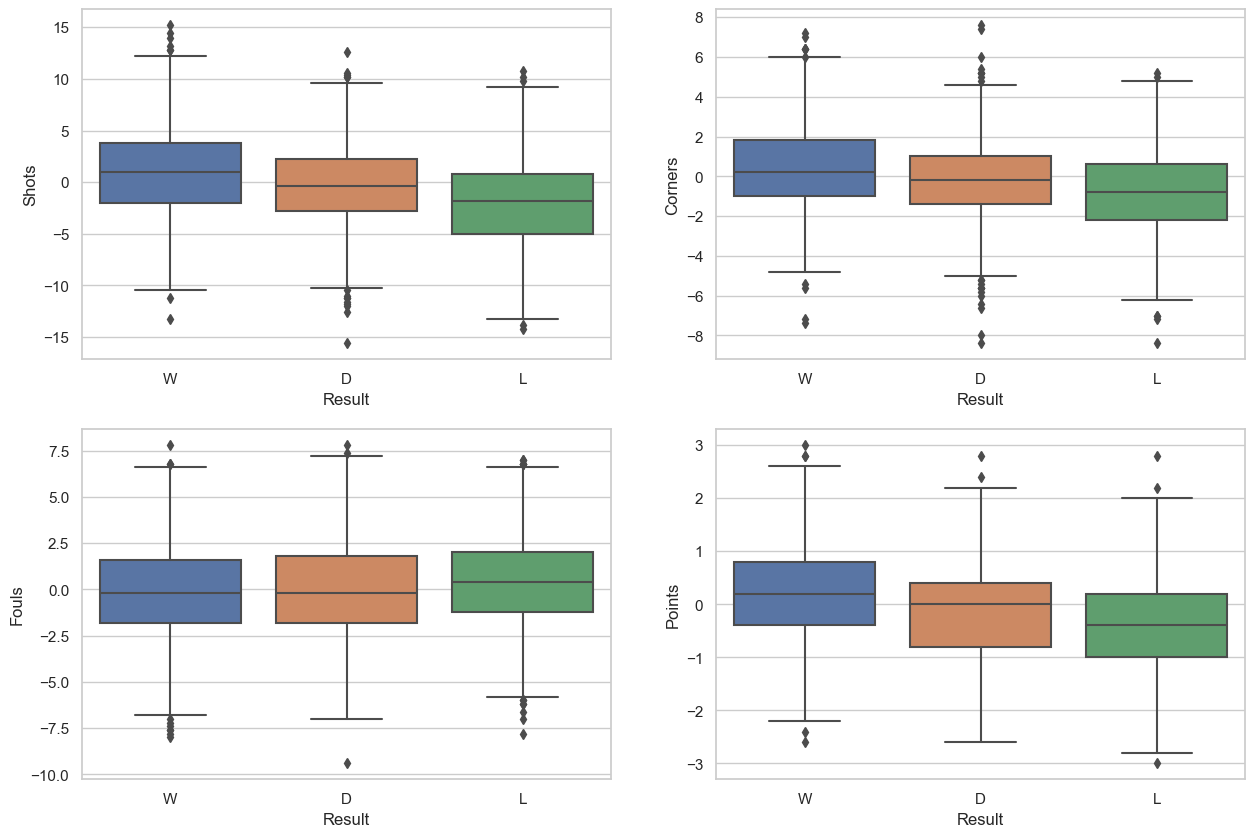

<Figure size 640x480 with 0 Axes>

In [20]:
# Shots, Corners, Fouls & Points

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x=df["Result"], y=df['Shots'])

plt.subplot(2, 2, 2)
sns.boxplot(x=df["Result"], y=df['Corners'])

plt.subplot(2, 2, 3)
sns.boxplot(x=df["Result"], y=df['Fouls'])

plt.subplot(2, 2, 4)
sns.boxplot(x=df["Result"], y=df['Points'])

plt.show()
plt.tight_layout()

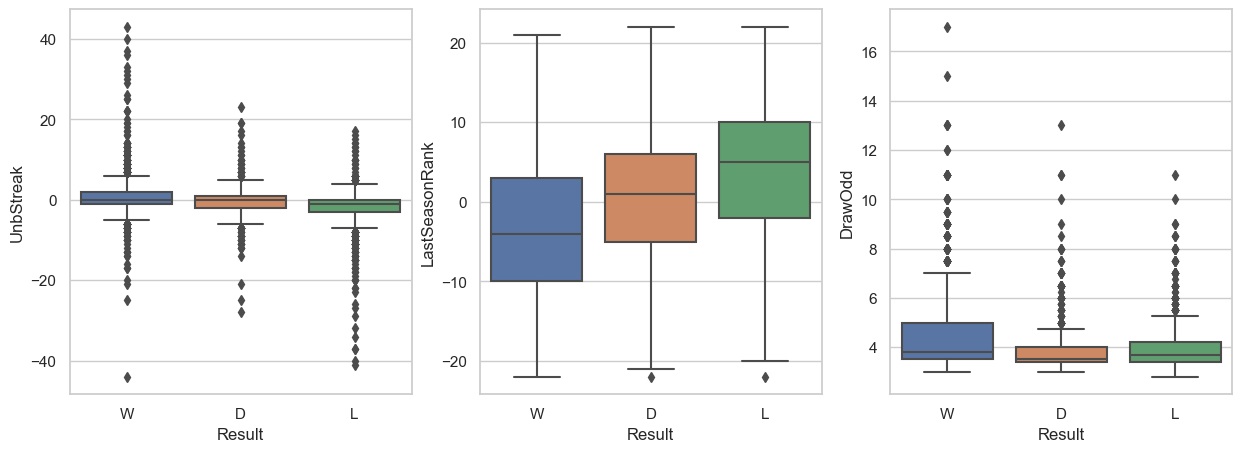

<Figure size 640x480 with 0 Axes>

In [21]:
# UnbStreak, LastSeasonRank and DrawOdd

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df["Result"], y=df['UnbStreak'])

plt.subplot(1, 3, 2)
sns.boxplot(x=df["Result"], y=df['LastSeasonRank'])

plt.subplot(1, 3, 3)
sns.boxplot(x=df["Result"], y=df['DrawOdd'])

plt.show()
plt.tight_layout()

In [22]:
df = df.drop(['Fouls', 'DrawOdd'], axis=1)

In [23]:
df.head()

,Shots,Corners,Points,UnbStreak,LastSeasonRank,Venue,Result
0,10.4,3.8,0.4,1.0,-12,12,W
1,-1.0,0.0,-0.2,-1.0,1,1,D
2,6.8,1.8,0.4,7.0,-6,14,W
3,3.4,2.0,1.0,5.0,-4,7,L
4,-2.4,-0.6,1.0,6.0,-1,6,W


In [24]:
df.columns

Index(['Shots', 'Corners', 'Points', 'UnbStreak', 'LastSeasonRank', 'Venue',
       'Result'],
      dtype='object')

In [25]:
df.shape

(3297, 7)

# 4. Model Building

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [29]:
df.Result.value_counts()

W    1496
L    1029
D     772
Name: Result, dtype: int64

## Finding Best Parameters for Models on Draw/ Non-Draw

In [32]:
# draw/non-draw
dnd_df = df.copy()

# label encode categorical data
dnd_df['Result'] = dnd_df['Result'].map({'D': 0, 'W': 1, 'L': 1})

In [33]:
# find the best parameter for each model on the whole dataset first

X = dnd_df.iloc[:, :-1]
y = dnd_df.iloc[:, -1]

# split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# numerical value standardization
dnd_sc = StandardScaler()
X_train.iloc[:, :-1] = dnd_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = dnd_sc.transform(X_test.iloc[:, :-1])

In [34]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 0)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100}


In [35]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.004832930238571752, 'penalty': 'l2', 'solver': 'liblinear'}


In [36]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 1e-20, 'tol': 1e-300}


In [37]:
from xgboost import XGBClassifier

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}


## Finding Best Parameters for Models on Win/ Draw/ Lose

In [38]:
# win/draw/lose
wdl_df = df.copy()

# label encode categorical data
wdl_le = LabelEncoder()
wdl_df['Result'] = wdl_le.fit_transform(wdl_df['Result'])

In [39]:
dict(zip(wdl_le.classes_, range(len(wdl_le.classes_))))

{'D': 0, 'L': 1, 'W': 2}

In [40]:
# find the best parameter for each model on the whole dataset first

X = wdl_df.iloc[:, :-1]
y = wdl_df.iloc[:, -1]

# split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# numerical value standardization
wdl_sc = StandardScaler()
X_train.iloc[:, :-1] = wdl_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wdl_sc.transform(X_test.iloc[:, :-1])

In [41]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 0)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 400}


In [42]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear'}


In [43]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 0.1, 'tol': 0.1}


In [44]:
from xgboost import XGBClassifier

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 180}


## Finding Best Parameters for Models on Draw/ Lose

In [45]:
# draw/lose
dl_df = df.copy()
dl_df = dl_df[(dl_df['Result'] == 'D') | (dl_df['Result'] == 'L')]

# label encode categorical data
dl_le = LabelEncoder()
dl_df['Result'] = dl_le.fit_transform(dl_df['Result'])

In [46]:
dict(zip(dl_le.classes_, range(len(dl_le.classes_))))

{'D': 0, 'L': 1}

In [47]:
# find the best parameter for each model on the whole dataset first

X = dl_df.iloc[:, :-1]
y = dl_df.iloc[:, -1]

# split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# numerical value standardization
dl_sc = StandardScaler()
X_train.iloc[:, :-1] = dl_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = dl_sc.transform(X_test.iloc[:, :-1])

In [48]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 0)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}


In [49]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}


In [50]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 0.1, 'tol': 0.1}


In [51]:
from xgboost import XGBClassifier

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 180}


## Finding Best Parameters for Models on Win/ Non-Win

In [32]:
# win/non-win
wnw_df = df.copy()

# label encode categorical data
wnw_df['Result'] = wnw_df['Result'].map({'D': 0, 'W': 1, 'L': 1})

In [33]:
# find the best parameter for each model on the whole dataset first

X = wnw_df.iloc[:, :-1]
y = wnw_df.iloc[:, -1]

# split to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

# numerical value standardization
wnw_sc = StandardScaler()
X_train.iloc[:, :-1] = wnw_sc.fit_transform(X_train.iloc[:, :-1])
X_test.iloc[:, :-1] = wnw_sc.transform(X_test.iloc[:, :-1])

In [34]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 0)
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 100}


In [35]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.004832930238571752, 'penalty': 'l2', 'solver': 'liblinear'}


In [36]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 1e-20, 'tol': 1e-300}


In [37]:
from xgboost import XGBClassifier

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60}
